In [1]:
#loading libraries

%matplotlib inline
!pip install dmba

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from scipy.stats import skew
import seaborn as sns
from sklearn.impute import SimpleImputer

import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.5 MB/s eta 0:00:00
Colab environment detected.


In [2]:
#loading the data
bank = pd.read_csv('bank-full.csv', sep=';')

In [3]:
#checking for the shape of the data and the data has 45211 rows and 17 columns
bank.shape

(45211, 17)

In [4]:
bank

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
0        unknown    5   may       261         1     -1         0  unknown   no  
1        unknown    5   may       151         1     -1         0  unknown   no  
2        unknown    5   may        76         1     -1         0  unknown   no  
3        unknown    5   may        92         1     -1         0  unknown   no  
4        unknown    5   may       198         1     -1         0  unknown   no  
...          ...  ...   ...       ...       ...    ...       ...      ...  ...  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no  

[45211 rows x 17 columns]

In [5]:
##checking for duplicates - dataset has no duplicates
bank.drop_duplicates(inplace=True)
bank.shape

(45211, 17)

In [6]:
#find the unique values to identify missing values labelled differently from the categorical features
#noted that some columns have some variables labelled "unknown"
for col in bank.select_dtypes(include='object').columns:
    print(col)
    print(bank[col].unique())

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital
['married' 'single' 'divorced']
education
['tertiary' 'secondary' 'unknown' 'primary']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


In [7]:
##dropping duration as per the variables description
##and contact since we are looking at a mordern model, it is likely that the only method of communication would be cellular
bank1 = bank.drop(columns=['duration', 'contact'])

In [8]:
##checking for missing values: no missing values in the data
bank1.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
# Imputing 'unknown' with the mode for job and education
for col in ['job', 'education']:
    mode = bank1.loc[bank1[col] != 'unknown', col].mode()[0]
    bank1[col] = bank1[col].replace('unknown', mode)

##leaving poutcome variables having unknown as it might hold some information

In [10]:
# To confirm the change in the dataset:
# Find columns that contain 'unknown' values and count them
unknown_counts2 = (bank1 == 'unknown').sum()

# Filter only columns where there is at least 1 'unknown'
unknown_columns2 = unknown_counts2[unknown_counts2 > 0]

print("Columns with 'unknown' values and their counts:")
print(unknown_columns2)

Columns with 'unknown' values and their counts:
poutcome    36959
dtype: int64


In [11]:
# chekcing for the unique values from categorical features after imputation
for col in bank1.select_dtypes(include='object').columns:
    print(col)
    print(bank1[col].unique())

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital
['married' 'single' 'divorced']
education
['tertiary' 'secondary' 'primary']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


In [12]:
##converting the target variable into binary values to 0/1
bank1['y'] = bank1['y'].replace({'yes': 1, 'no': 0})

for col in ['default', 'housing', 'loan']:
    bank1[col] = bank1[col].replace({'yes': 1, 'no': 0})

/tmp/ipython-input-1534829306.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank1['y'] = bank1['y'].replace({'yes': 1, 'no': 0})
/tmp/ipython-input-1534829306.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank1[col] = bank1[col].replace({'yes': 1, 'no': 0})


In [13]:
## identifying and dropping the target variable - y(has the client subscribed a term deposit?)
X = bank1.drop(columns=['y'])
y = bank1['y']

In [14]:
##labelling the numerical/categorical variables
numeric_cols = ['age', 'balance', 'campaign', 'pdays', 'previous']
categorical_cols = [col for col in X.columns if col not in numeric_cols]

In [15]:
# Redefine numeric and categorical columns after mapping
# The numeric columns now include the binary encoded columns
numeric_cols = ['age', 'balance', 'campaign', 'pdays', 'previous', 'default', 'housing', 'loan']

categorical_cols = [col for col in bank1.columns if col not in numeric_cols and col != 'y']

# Explicitly cast dtypes to ensure correct handling by preprocessor
for col in numeric_cols:
    bank1[col] = bank1[col].astype(float)

for col in categorical_cols:
    bank1[col] = bank1[col].astype(object)

# Create numerical transformer with imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])

# Create categorical transformer with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [16]:
bank1.head()

age           job  marital  education  default  balance  housing  loan  \
0  58.0    management  married   tertiary      0.0   2143.0      1.0   0.0   
1  44.0    technician   single  secondary      0.0     29.0      1.0   0.0   
2  33.0  entrepreneur  married  secondary      0.0      2.0      1.0   1.0   
3  47.0   blue-collar  married  secondary      0.0   1506.0      1.0   0.0   
4  33.0   blue-collar   single  secondary      0.0      1.0      0.0   0.0   

  day month  campaign  pdays  previous poutcome  y  
0   5   may       1.0   -1.0       0.0  unknown  0  
1   5   may       1.0   -1.0       0.0  unknown  0  
2   5   may       1.0   -1.0       0.0  unknown  0  
3   5   may       1.0   -1.0       0.0  unknown  0  
4   5   may       1.0   -1.0       0.0  unknown  0

In [ ]:
#checking the data type of the variables
bank1.dtypes

age          float64
job           object
marital       object
education     object
default      float64
balance      float64
housing      float64
loan         float64
day          float64
month         object
campaign     float64
pdays        float64
previous     float64
poutcome      object
y              int64
dtype: object

In [ ]:
##Exploring the numeric features
bank1[numeric_cols].describe()

age       default        balance       housing          loan  \
count  45211.000000  45211.000000   45211.000000  45211.000000  45211.000000   
mean      40.936210      0.018027    1362.272058      0.555838      0.160226   
std       10.618762      0.133049    3044.765829      0.496878      0.366820   
min       18.000000      0.000000   -8019.000000      0.000000      0.000000   
25%       33.000000      0.000000      72.000000      0.000000      0.000000   
50%       39.000000      0.000000     448.000000      1.000000      0.000000   
75%       48.000000      0.000000    1428.000000      1.000000      0.000000   
max       95.000000      1.000000  102127.000000      1.000000      1.000000   

                day      campaign         pdays      previous  
count  45211.000000  45211.000000  45211.000000  45211.000000  
mean      15.806419      2.763841     40.197828      0.580323  
std        8.322476      3.098021    100.128746      2.303441  
min        1.000000      1.000000     -1.000000      0.000000  
25%        8.000000      1.000000     -1.000000      0.000000  
50%       16.000000      2.000000     -1.000000      0.000000  
75%       21.000000      3.000000     -1.000000      0.000000  
max       31.000000     63.000000    871.000000    275.000000

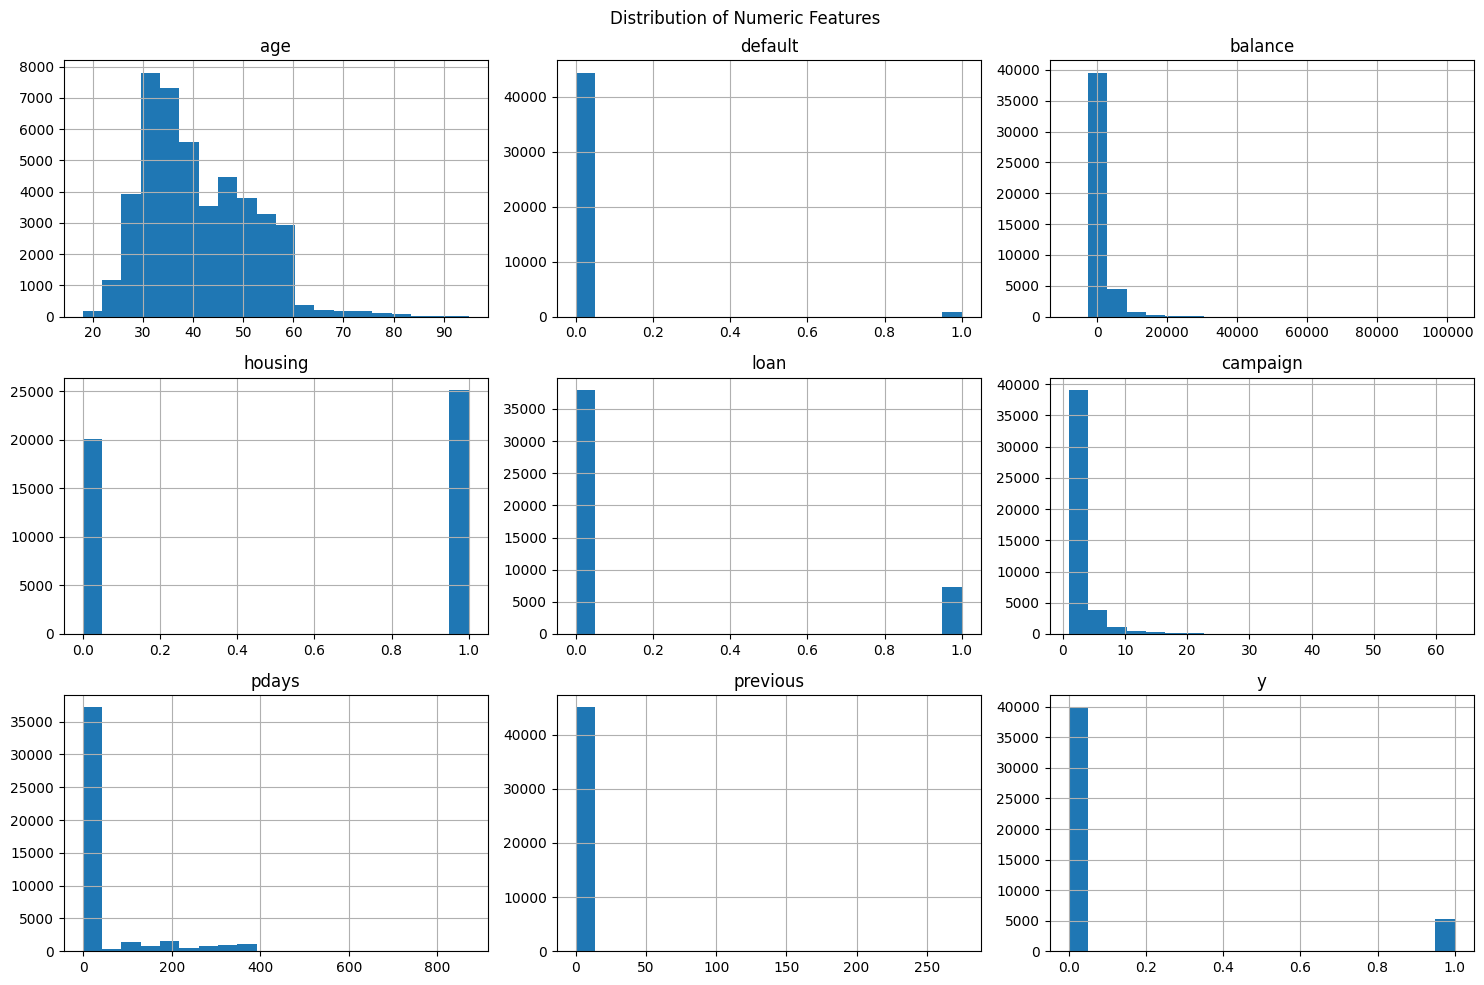

In [17]:
#checking the distribution of the numeric features
bank1.select_dtypes(include=['int64', 'float64']).hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Features")
plt.tight_layout()
plt.show()

age          0.684795
balance      8.360031
campaign     4.898488
pdays        2.615629
previous    41.845066
default      7.245135
housing     -0.224759
loan         1.852556
dtype: float64


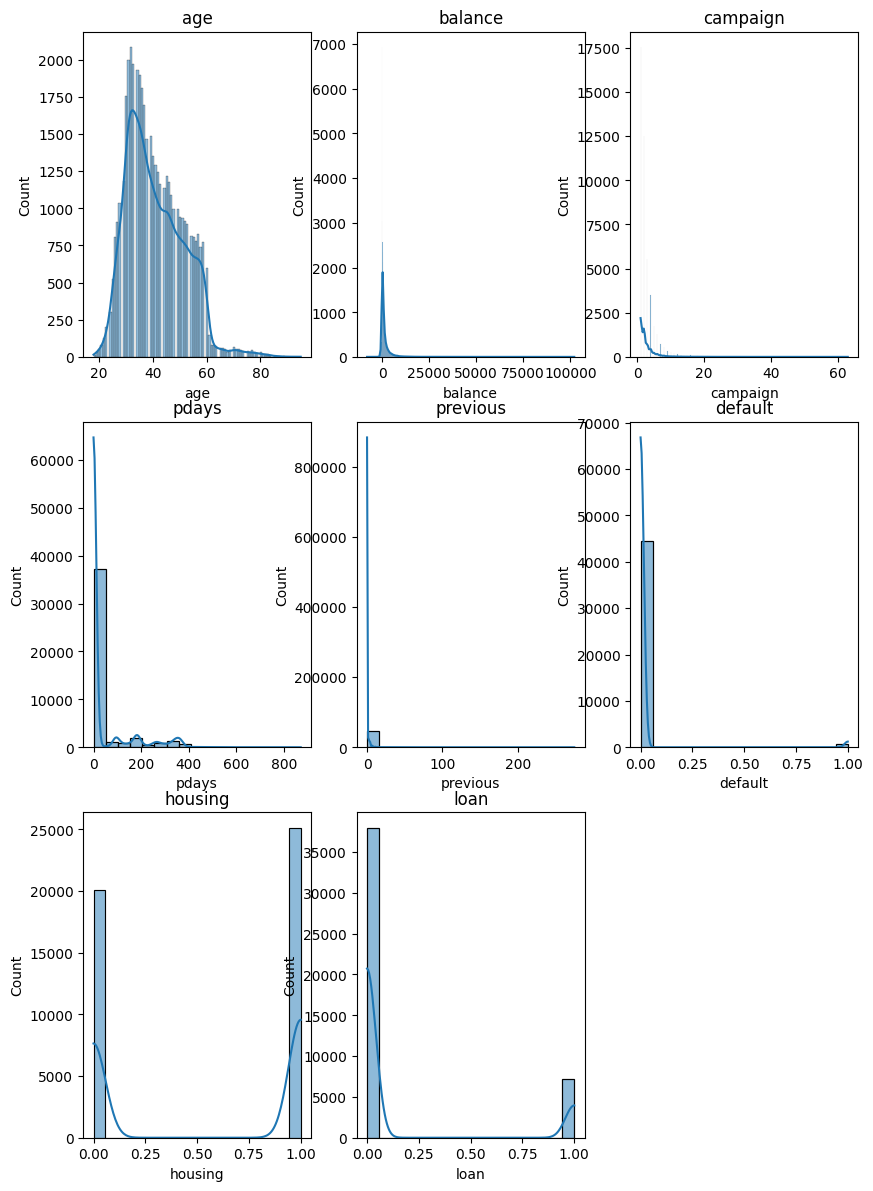

In [19]:
##finding the skewness for the numerical variables - all numerical variables except housing are positively skewed
print(bank1[numeric_cols].apply(skew))

plt.figure(figsize=(10,60), facecolor='white')
plotnumber =1
for num in numeric_cols:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(bank1[num],kde=True)
    plt.title(num)
    plt.xlabel(num)
    plotnumber+=1
plt.show()

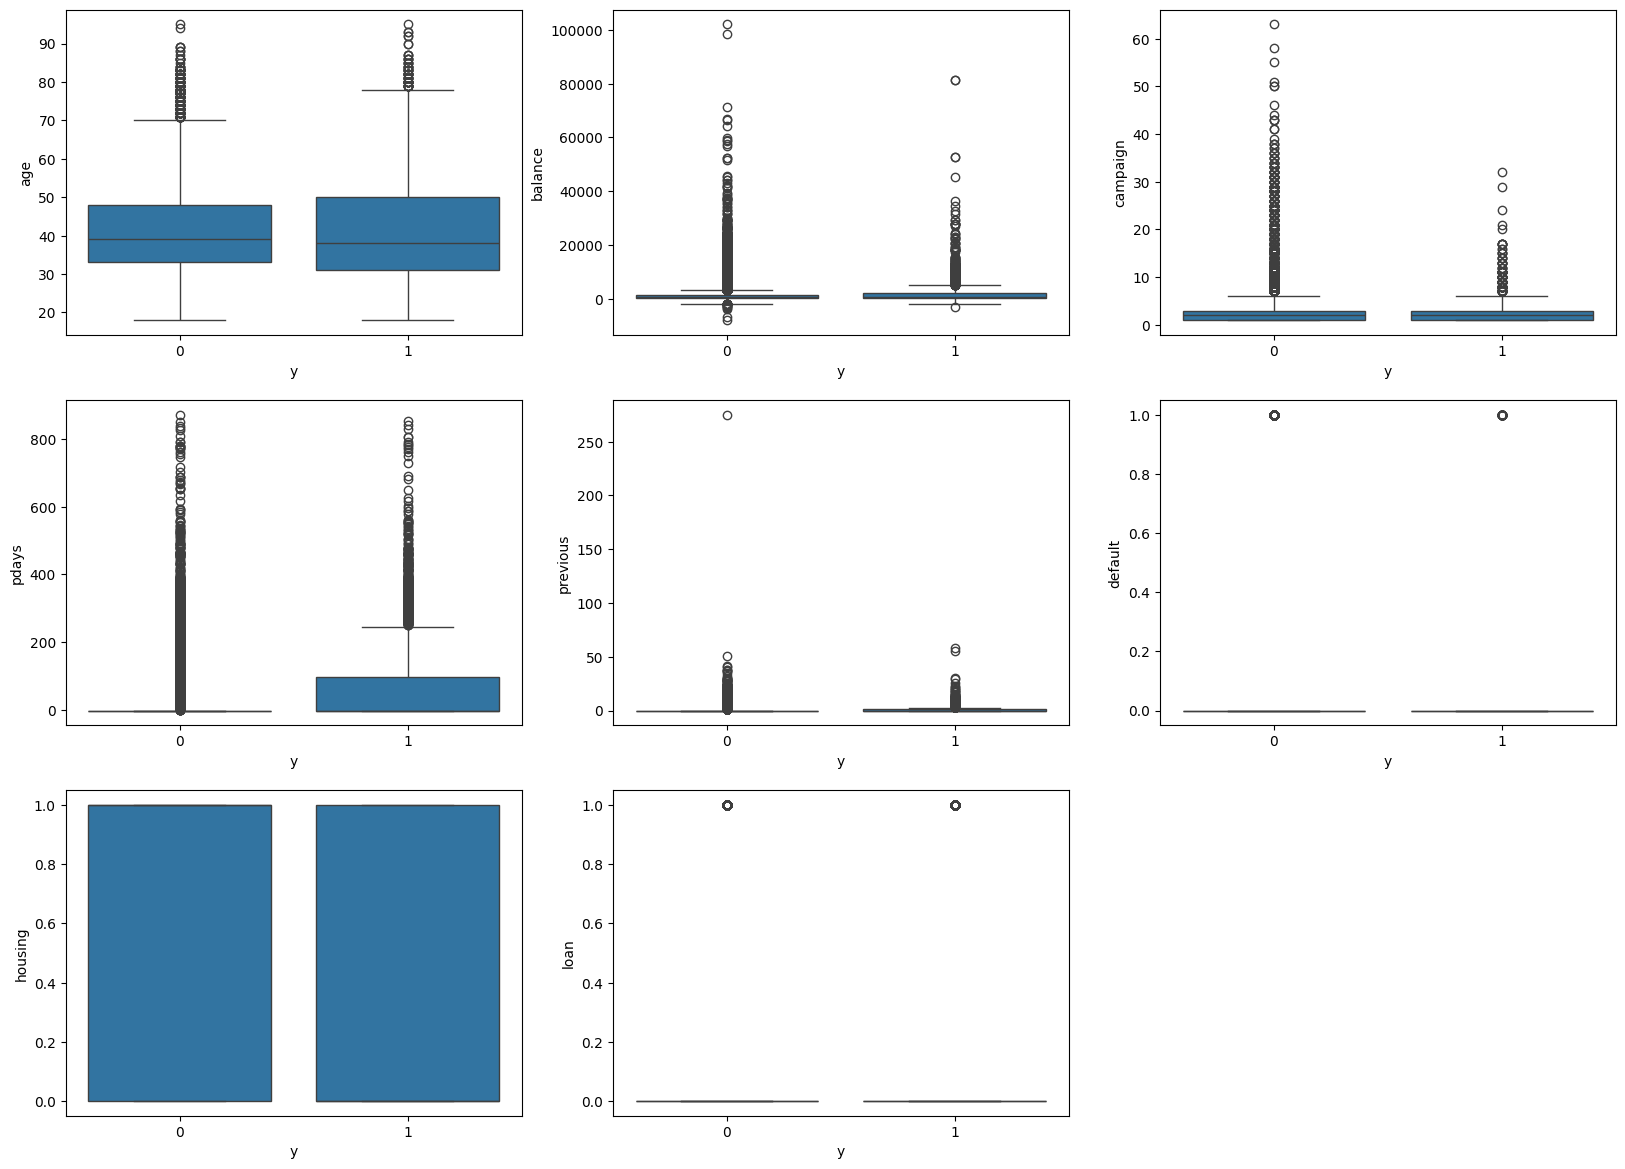

In [20]:
#boxplots to show target distribution with respect numerical features
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for num in numeric_cols:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x="y", y= bank1[num], data=bank1)
    plt.xlabel("y")
    plt.ylabel(num)
    plotnumber+=1
plt.show()

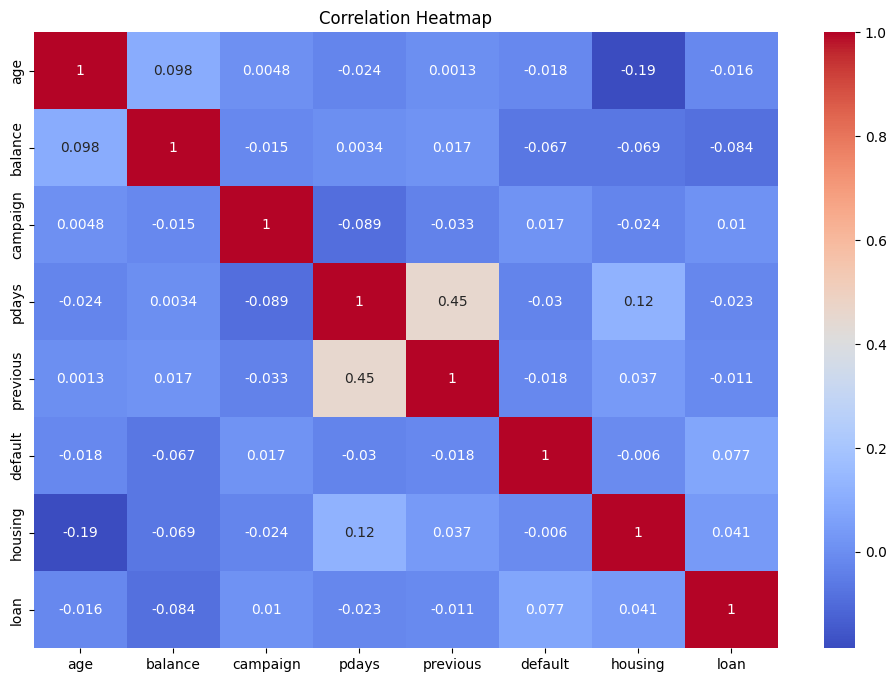

In [21]:
## Checking for correlation in the numerical variables
plt.figure(figsize=(12, 8))
sns.heatmap(bank1[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

pdays and previous have the strongest linear relationship. The other numerical features are largely uncorrelated with each other.

In [22]:
## Exploring Categorical variables to check which variables have 1 unique value - none of the variables have only 1 unique value
## This is done to check if the data has some undetected missing values
bank1.describe(include='object')

job  marital  education    day  month poutcome
count         45211    45211      45211  45211  45211    45211
unique           11        3          3     31     12        4
top     blue-collar  married  secondary     20    may  unknown
freq          10020    27214      25059   2752  13766    36959

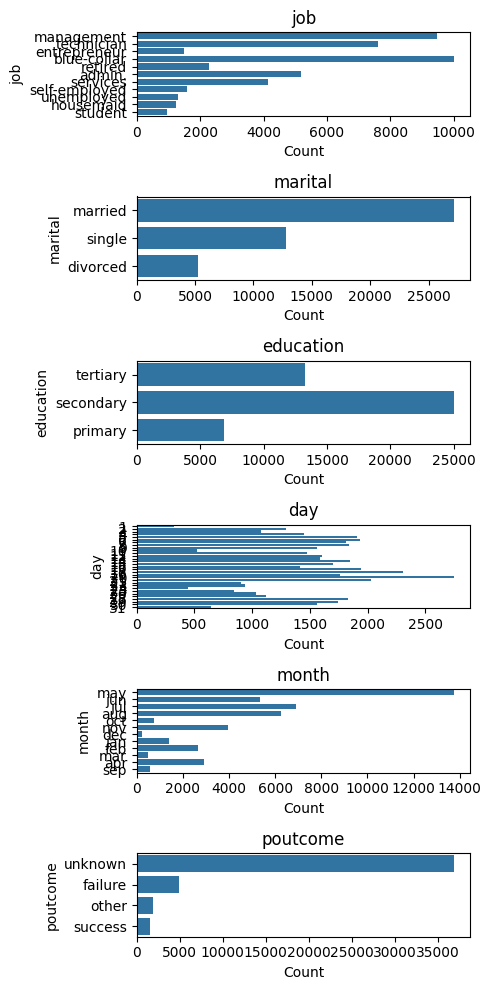

In [23]:
#find the categorical variables count
plt.figure(figsize=(5,10), facecolor='white')
plotnumber =1
for col in categorical_cols:
    ax = plt.subplot(len(categorical_cols), 1, plotnumber)
    sns.countplot(y=col, data=bank1, ax=ax)
    plt.xlabel("Count")
    plt.title(col)
    plotnumber+=1
plt.tight_layout()
plt.show()

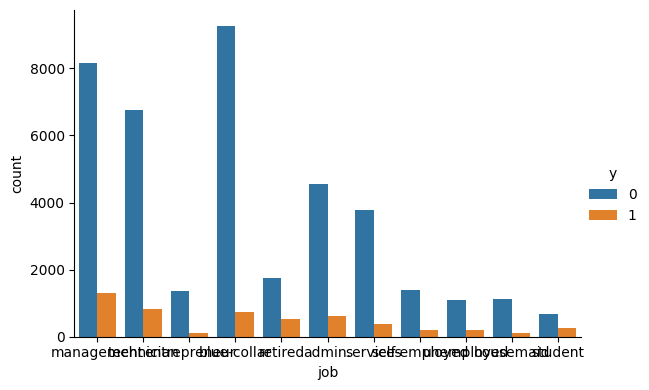

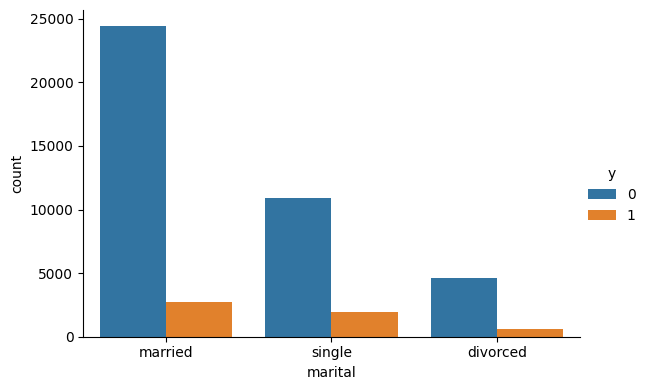

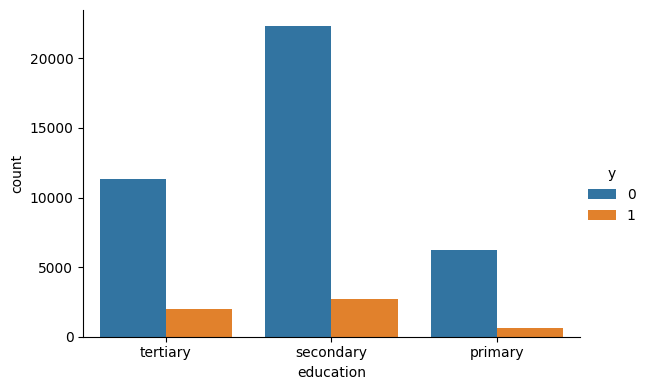

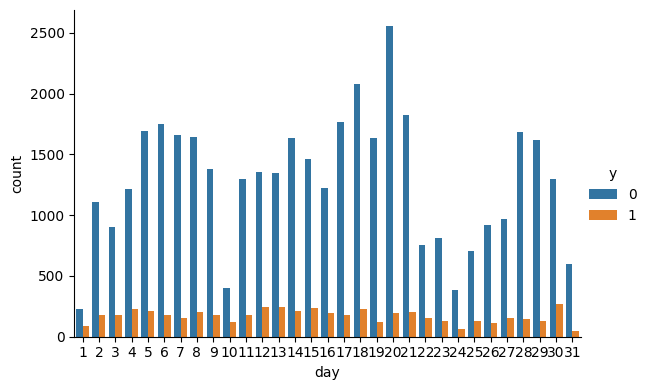

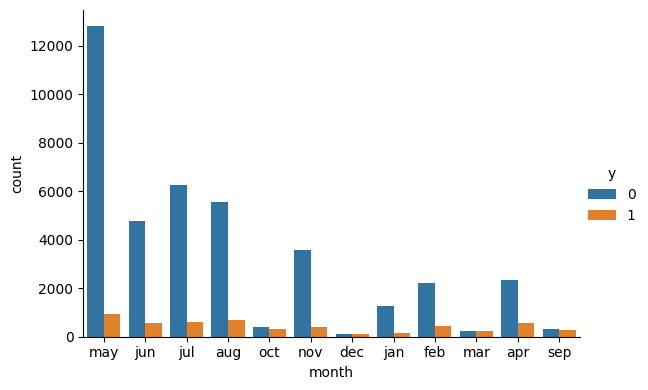

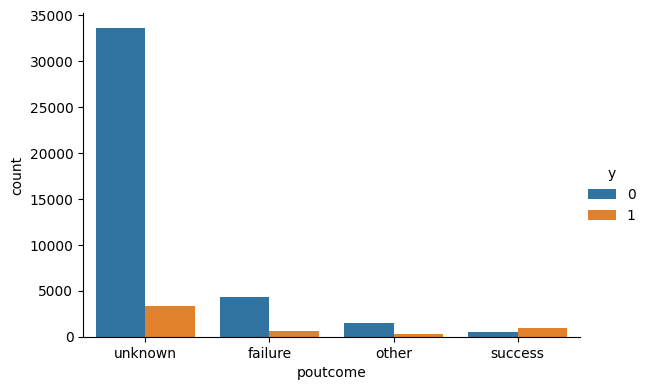

In [24]:
#Plotting out the relationship between categorical variables and the target variable
for col in categorical_cols:
    sns.catplot(x=col, hue='y', kind='count', data=bank1, height=4, aspect=1.5)
plt.show()

In [ ]:
##how do i find the correlation for the categorical variables

In [25]:
# percentage of class present in target variable(y)
print("percentage of NO and YES\n",bank1["y"].value_counts()/len(bank)*100)

percentage of NO and YES
 y
0    88.30152
1    11.69848
Name: count, dtype: float64


Index(['job', 'marital', 'education', 'day', 'month', 'poutcome'], dtype='object')


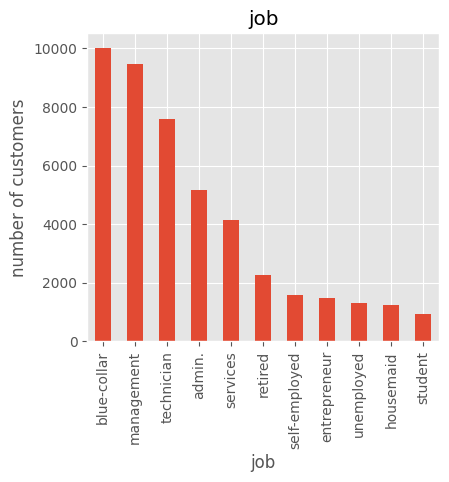

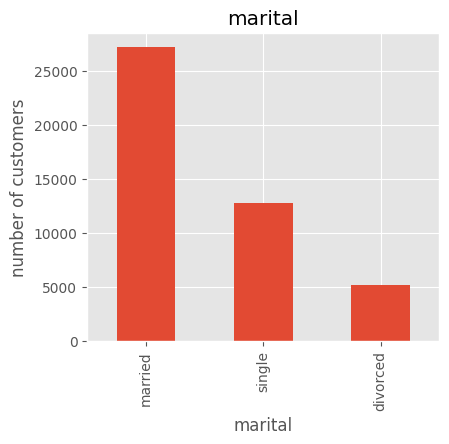

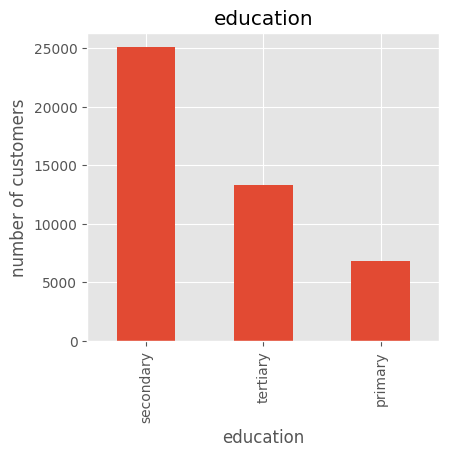

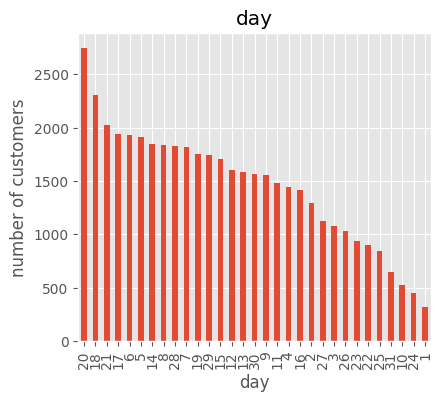

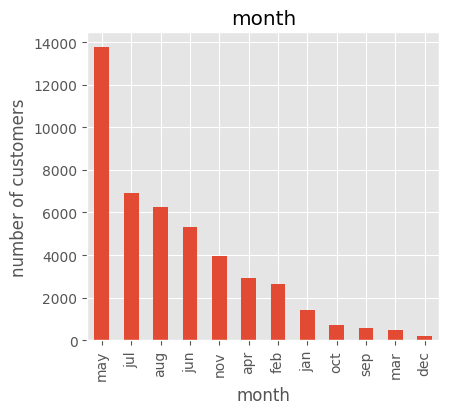

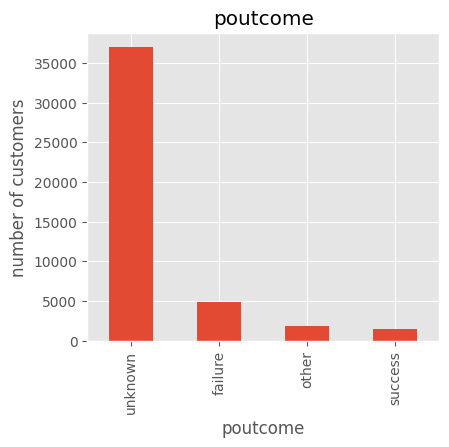

In [26]:
# indentifying the categorical variables
cat_var = bank1.select_dtypes(include=['object']).columns
print(cat_var)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    bank1[column].value_counts().plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("number of customers")
    plt.title(column)
    plt.xticks(rotation=90)
    plt.show()

In [36]:
#Resampling due to dataset imbalance
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

X = bank1.drop(columns=['y'])
y = bank1['y']

# Split data - Using the stratified split from cell l1KSRnmNRaBW
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing to the training data
x_train_processed = preprocessor.fit_transform(x_train)

# Use the correct numeric_cols list defined after mapping
numeric_cols_preprocessor = preprocessor.transformers_[0][2]
for col in numeric_cols_preprocessor:
    print(f"{col}: {x_train[col].unique()[:10]}")


#initialising oversampling
smote= SMOTETomek(sampling_strategy=0.75, random_state=42)

#implementing oversampling to training data
x_sm, y_sm= smote.fit_resample(x_train_processed, y_train)

# x_sm and y_sm are the resampled data

# target class count of resampled dataset
print("Value counts before SMOTETomek:")
print(y_train.value_counts())
print("\nValue counts after SMOTETomek:")
print(y_sm.value_counts())

age: [36. 24. 44. 48. 38. 50. 46. 45. 63. 55.]
balance: [ 861. 4126.  244.    0.  257. 1513. 4315. -780.  474.  248.]
campaign: [ 2.  4. 11. 10.  1.  7.  5.  3. 26. 18.]
pdays: [ -1. 185. 555. 362. 370. 299. 367. 184. 403.   6.]
previous: [0. 7. 2. 1. 6. 5. 8. 4. 3. 9.]
default: [0. 1.]
housing: [0. 1.]
loan: [0. 1.]
Value counts before SMOTETomek:
y
0    31937
1     4231
Name: count, dtype: int64

Value counts after SMOTETomek:
y
0    31139
1    23154
Name: count, dtype: int64


In [34]:
# Print shapes of relevant data splits
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of x_sm (resampled training features):", x_sm.shape)
print("Shape of y_sm (resampled training target):", y_sm.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (36168, 14)
Shape of x_test: (9043, 14)
Shape of x_sm (resampled training features): (54293, 72)
Shape of y_sm (resampled training target): (54293,)
Shape of y_train: (36168,)
Shape of y_test: (9043,)


In [37]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary

fullClassTree = DecisionTreeClassifier(random_state=42)
fullClassTree.fit(x_sm, y_sm)

DecisionTreeClassifier(random_state=42)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.153236 to fit


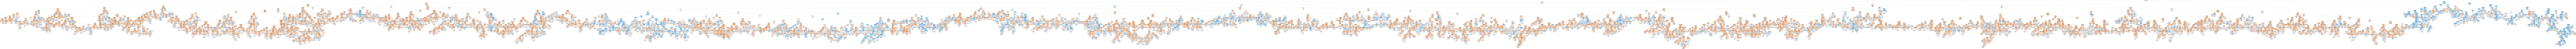

In [ ]:
#Plotting decision tree
feature_names = preprocessor.get_feature_names_out()
x_sm_df = pd.DataFrame(x_sm, columns=feature_names)
plotDecisionTree(fullClassTree, feature_names=x_sm_df.columns)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

# Apply preprocessing to the test data using the fitted preprocessor
x_test_processed = preprocessor.transform(x_test)

# Make predictions on the test data
y_pred_tree = fullClassTree.predict(x_test_processed)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      7985
           1       0.31      0.33      0.32      1058

    accuracy                           0.83      9043
   macro avg       0.61      0.61      0.61      9043
weighted avg       0.84      0.83      0.84      9043



In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[7198  787]
 [ 711  347]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(x_sm, y_sm)

# Print the best parameters
print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
# Get the best model from the grid search
best_tree = grid_search.best_estimator_

# Make predictions on the test data
y_pred_best_tree = best_tree.predict(x_test_processed)

In [ ]:
print(classification_report(y_test, y_pred_best_tree))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7985
           1       0.29      0.33      0.31      1058

    accuracy                           0.83      9043
   macro avg       0.60      0.61      0.61      9043
weighted avg       0.84      0.83      0.83      9043



In [ ]:
classes = ['yes', 'no']
classificationSummary(y_test, y_pred_best_tree, class_names = classes)

Confusion Matrix (Accuracy 0.8263)

       Prediction
Actual  yes   no
   yes 7120  865
    no  706  352


In [ ]:
## Regression Models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Apply preprocessing to the test data using the fitted preprocessor
x_test_processed = preprocessor.transform(x_test)

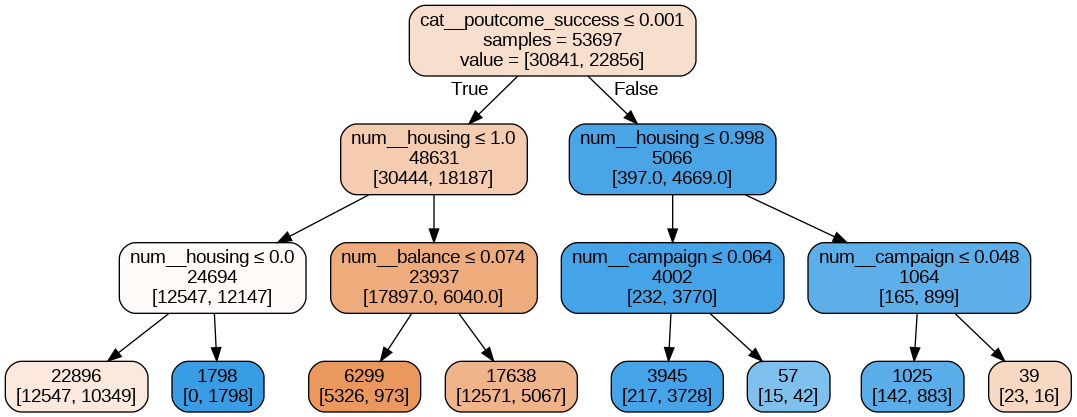

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree

# Creating a new, simplified decision tree for visualization
simple_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
simple_tree.fit(x_sm, y_sm)

# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Plot the simplified decision tree
plotDecisionTree(simple_tree, feature_names=feature_names)

In [ ]:
# Logistic Regression model
model = LogisticRegression(random_state=42, solver='liblinear', C=1e42)
model.fit(x_sm, y_sm)

LogisticRegression(C=1e+42, random_state=42, solver='liblinear')

In [ ]:
model.intercept_

array([0.36519792])

In [ ]:
#these are not probabilities either we need to change them to probabilities
model.coef_

array([[-0.40054655, -0.4917761 ,  2.67556373, -0.64027373, -0.63971118,
        -0.19584179, -5.19130694,  0.19847512,  9.30162663,  0.12409573,
         0.01748732, -0.24338806, -0.50238977,  0.05742165,  0.7072175 ,
        -0.28097739, -0.03763495,  0.41023484,  0.05306467,  0.06006639,
         0.1747556 , -0.06669496,  0.25713728, -0.08303231,  0.11675861,
         0.33147162,  0.27014877,  0.09504915, -1.00148251, -0.21704423,
         1.37897646,  0.27562349, -0.739973  , -0.47239344, -0.36267298,
        -0.5935713 ,  0.76939785,  1.07218232, -0.67863613,  0.9347914 ,
        -0.56044743, -0.38653574,  1.88628095, -0.57409985]])

In [ ]:
#Showing the coefficients with variable names - putting them in a table
# Getting feature names after preprocessing
feature_names_out = preprocessor.get_feature_names_out()

# Creating DataFrame of coefficients with post-preprocessing feature names
pd.DataFrame({'coef': model.coef_[0]}, index=feature_names_out)

coef
num__age               -0.400547
num__default           -0.491776
num__balance            2.675564
num__housing           -0.640274
num__loan              -0.639711
num__day               -0.195842
num__campaign          -5.191307
num__pdays              0.198475
num__previous           9.301627
cat__job_admin.         0.124096
cat__job_blue-collar    0.017487
cat__job_entrepreneur  -0.243388
cat__job_housemaid     -0.502390
cat__job_management     0.057422
cat__job_retired        0.707217
cat__job_self-employed -0.280977
cat__job_services      -0.037635
cat__job_student        0.410235
cat__job_technician     0.053065
cat__job_unemployed     0.060066
cat__marital_divorced   0.174756
cat__marital_married   -0.066695
cat__marital_single     0.257137
cat__education_0       -0.083032
cat__education_1        0.116759
cat__education_2        0.331472
cat__contact_cellular   0.270149
cat__contact_telephone  0.095049
cat__month_1           -1.001483
cat__month_2           -0.217044
cat__month_3            1.378976
cat__month_4            0.275623
cat__month_5           -0.739973
cat__month_6           -0.472393
cat__month_7           -0.362673
cat__month_8           -0.593571
cat__month_9            0.769398
cat__month_10           1.072182
cat__month_11          -0.678636
cat__month_12           0.934791
cat__poutcome_failure  -0.560447
cat__poutcome_other    -0.386536
cat__poutcome_success   1.886281
cat__poutcome_unknown  -0.574100

In [ ]:
# Get the 44 feature names that were created by the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Now we have 44 coefficients, 44 odds ratios, and 44 feature names
pd.DataFrame({'coef': model.coef_[0], 'odds': np.e**model.coef_[0], 'variable': feature_names})

coef          odds                variable
0  -0.400547      0.669954                num__age
1  -0.491776      0.611539            num__default
2   2.675564     14.520533            num__balance
3  -0.640274      0.527148            num__housing
4  -0.639711      0.527445               num__loan
5  -0.195842      0.822142                num__day
6  -5.191307      0.005565           num__campaign
7   0.198475      1.219542              num__pdays
8   9.301627  10955.825804           num__previous
9   0.124096      1.132124         cat__job_admin.
10  0.017487      1.017641    cat__job_blue-collar
11 -0.243388      0.783967   cat__job_entrepreneur
12 -0.502390      0.605083      cat__job_housemaid
13  0.057422      1.059102     cat__job_management
14  0.707217      2.028340        cat__job_retired
15 -0.280977      0.755045  cat__job_self-employed
16 -0.037635      0.963064       cat__job_services
17  0.410235      1.507172        cat__job_student
18  0.053065      1.054498     cat__job_technician
19  0.060066      1.061907     cat__job_unemployed
20  0.174756      1.190955   cat__marital_divorced
21 -0.066695      0.935481    cat__marital_married
22  0.257137      1.293223     cat__marital_single
23 -0.083032      0.920321        cat__education_0
24  0.116759      1.123848        cat__education_1
25  0.331472      1.393017        cat__education_2
26  0.270149      1.310159   cat__contact_cellular
27  0.095049      1.099713  cat__contact_telephone
28 -1.001483      0.367334            cat__month_1
29 -0.217044      0.804894            cat__month_2
30  1.378976      3.970835            cat__month_3
31  0.275623      1.317352            cat__month_4
32 -0.739973      0.477127            cat__month_5
33 -0.472393      0.623508            cat__month_6
34 -0.362673      0.695814            cat__month_7
35 -0.593571      0.552351            cat__month_8
36  0.769398      2.158466            cat__month_9
37  1.072182      2.921749           cat__month_10
38 -0.678636      0.507308           cat__month_11
39  0.934791      2.546682           cat__month_12
40 -0.560447      0.570954   cat__poutcome_failure
41 -0.386536      0.679406     cat__poutcome_other
42  1.886281      6.594797   cat__poutcome_success
43 -0.574100      0.563212   cat__poutcome_unknown

In [ ]:
#we predict the probability using the preprocessed test data
model_prob = model.predict_proba(x_test_processed)
model_prob

array([[0.89326019, 0.10673981],
       [0.80536874, 0.19463126],
       [0.79610645, 0.20389355],
       ...,
       [0.73022241, 0.26977759],
       [0.47895801, 0.52104199],
       [0.76922413, 0.23077587]])

In [ ]:
##telling it what to predict
model_pred = model.predict(x_test_processed)

In [ ]:
#Creating a table of probabilities and predictions
logit_result = pd.DataFrame({'actual': y_test,
                             'p_0': [p[0] for p in model_prob],
                             'p_1': [p[1] for p in model_prob],
                             'predicted': model_pred})
display(logit_result.head())

actual       p_0       p_1  predicted
1392        0  0.893260  0.106740          0
7518        0  0.805369  0.194631          0
12007       0  0.796106  0.203894          0
5536        0  0.849282  0.150718          0
29816       0  0.579610  0.420390          0

In [ ]:
classificationSummary(y_sm, model.predict(x_sm))

Confusion Matrix (Accuracy 0.7243)

       Prediction
Actual     0     1
     0 26980  3861
     1 10942 11914


In [ ]:
classificationSummary(y_train, model.predict(x_train_processed))

Confusion Matrix (Accuracy 0.8286)

       Prediction
Actual     0     1
     0 27834  4103
     1  2098  2133


<Axes: xlabel='# records', ylabel='# cumulative gains'>

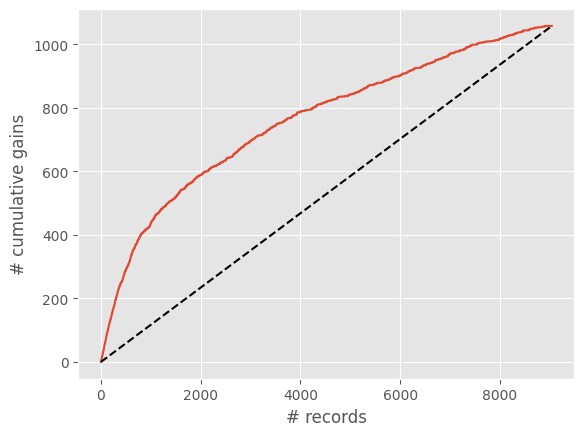

In [ ]:
from dmba import gainsChart

logit_result = logit_result.sort_values(by='p_1', ascending=False)
gainsChart(logit_result.actual)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, solver='liblinear')
log_reg.fit(x_sm, y_sm)

# Make predictions on the test data
y_pred_log_reg = log_reg.predict(x_test_processed)

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))

# Display the confusion matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("\nConfusion Matrix for Logistic Regression:")
print(cm_log_reg)

NameError: name 'x_test_processed' is not defined

In [ ]:
# Running a random forest to fidn feature importances
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_sm, y_sm)

# Make predictions on the test data
y_pred_rf = rf_model.predict(x_test_processed)

# Print the classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Display the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix for Random Forest:")
print(cm_rf)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      7985
           1       0.50      0.32      0.39      1058

    accuracy                           0.88      9043
   macro avg       0.71      0.64      0.66      9043
weighted avg       0.87      0.88      0.87      9043


Confusion Matrix for Random Forest:
[[7649  336]
 [ 716  342]]


In [30]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_sm, y_sm)

# Make predictions on the test data
y_pred_rf = rf_model.predict(x_test_processed)

# Print the classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Display the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix for Random Forest:")
print(cm_rf)

NameError: name 'x_test_processed' is not defined

                   feature  importance
8          cat__job_admin.    0.170050
7                num__loan    0.151667
3               num__pdays    0.127643
6             num__housing    0.118801
0                 num__age    0.115862
10   cat__job_entrepreneur    0.042108
27            cat__day_3.0    0.037984
4            num__previous    0.037574
9     cat__job_blue-collar    0.036111
1             num__balance    0.030887
5             num__default    0.016932
28            cat__day_4.0    0.011966
23      cat__education_1.0    0.009908
20    cat__marital_married    0.009093
15       cat__job_services    0.009010
12     cat__job_management    0.008718
25            cat__day_1.0    0.008485
24      cat__education_2.0    0.008013
11      cat__job_housemaid    0.007785
18     cat__job_unemployed    0.006303
22      cat__education_0.0    0.005588
16        cat__job_student    0.005151
17     cat__job_technician    0.004117
21     cat__marital_single    0.003660
13        cat__job_retire

Text(0, 0.5, 'Importance')

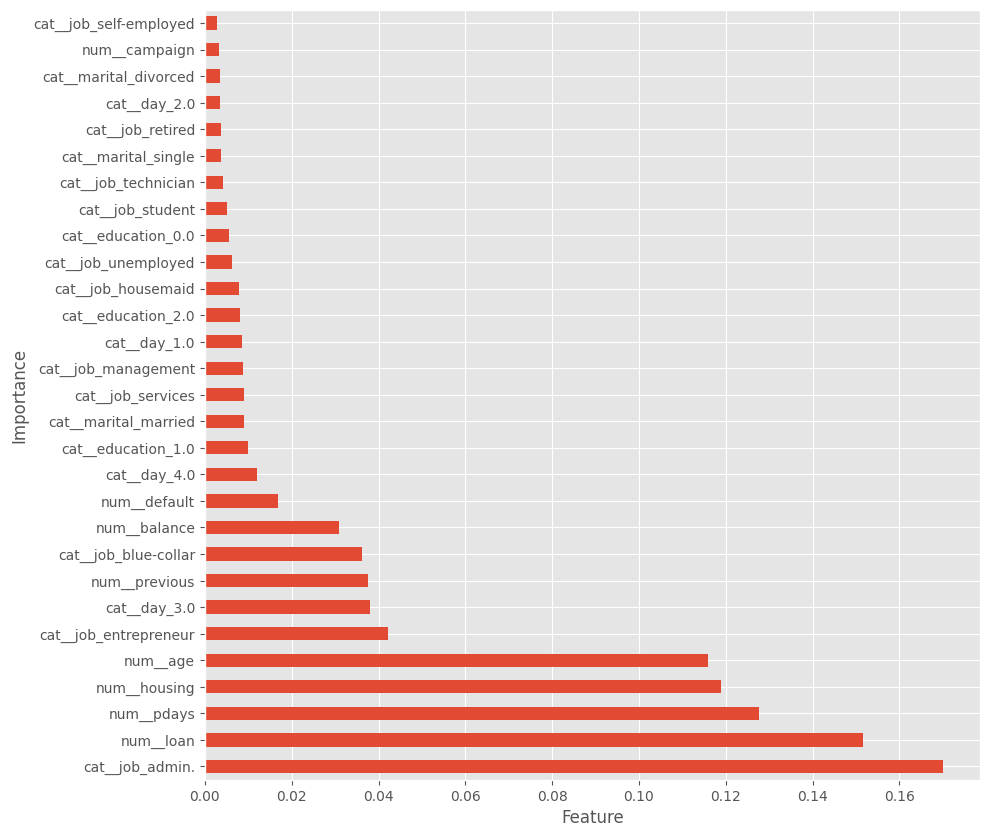

In [ ]:
#Feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# This is a workaround to solve for a potential mismatch in feature dimensions
if len(feature_names) > len(importances):
       feature_names = feature_names[:len(importances)]
elif len(feature_names) < len(importances):
    padding_length = len(importances) - len(feature_names)
    feature_names = list(feature_names) + [f'unknown_feature_{i}' for i in range(padding_length)]


# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Plot the feature importances
ax = feature_importance_df.plot(kind='barh', x='feature', y='importance', legend = False, figsize=(10, 10))
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')

In [ ]:
# Get the names of the top features from the feature importance dataframe
top_n = 20
top_features = feature_importance_df['feature'].head(top_n).tolist()

print("Selected top features:")
print(top_features)

# Get the full list of feature names from the preprocessor
full_feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for x_sm using the first 29 names from the full list (assuming order alignment)
if x_sm.shape[1] <= len(full_feature_names):
    x_sm_df = pd.DataFrame(x_sm, columns=full_feature_names[:x_sm.shape[1]])
else:
     x_sm_df = pd.DataFrame(x_sm)
     print("Warning: x_sm has more columns than preprocessor names. Using default column names.")


# Create a DataFrame for x_test_processed using the first 29 names from the full list (assuming order alignment)
if x_test_processed.shape[1] <= len(full_feature_names):
    x_test_processed_df = pd.DataFrame(x_test_processed, columns=full_feature_names[:x_test_processed.shape[1]])
else:
    x_test_processed_df = pd.DataFrame(x_test_processed)
    print("Warning: x_test_processed has more columns than preprocessor names. Using default column names.")


# Select the top features from x_sm_df and x_test_processed_df by name
x_sm_top = x_sm_df[top_features]
x_test_top = x_test_processed_df[top_features]


print(f"\nNew training data shape: {x_sm_top.shape}")
print(f"New test data shape: {x_test_top.shape}")

Selected top features:
['cat__job_admin.', 'num__loan', 'num__pdays', 'num__housing', 'num__age', 'cat__job_entrepreneur', 'cat__day_3.0', 'num__previous', 'cat__job_blue-collar', 'num__balance', 'num__default', 'cat__day_4.0', 'cat__education_1.0', 'cat__marital_married', 'cat__job_services', 'cat__job_management', 'cat__day_1.0', 'cat__education_2.0', 'cat__job_housemaid', 'cat__job_unemployed']

New training data shape: (54071, 20)
New test data shape: (9043, 20)


In [31]:
# Initialize and train a new Random Forest model on the top N features
rf_model_top = RandomForestClassifier()
rf_model_top.fit(x_sm_top, y_sm)

# Make predictions on the test data with top N features
y_pred_rf_top = rf_model_top.predict(x_test_top)

# Print the classification report
print("\nClassification Report for Random Forest with Top Features:")
print(classification_report(y_test, y_pred_rf_top))

# Display the confusion matrix
cm_rf_top = confusion_matrix(y_test, y_pred_rf_top)
print("\nConfusion Matrix for Random Forest with Top Features:")
print(cm_rf_top)

NameError: name 'x_sm_top' is not defined

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(x_sm, y_sm)

# Make predictions on the test data
y_pred_gb = gb_model.predict(x_test_processed)

# Print the classification report
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

# Display the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
print("\nConfusion Matrix for Gradient Boosting:")
print(cm_gb)

NameError: name 'x_test_processed' is not defined

In [ ]:
##Boosted Tree
boost = GradientBoostingClassifier()
boost.fit(x_sm, y_sm)
classificationSummary(y_test, boost.predict(x_test_processed))

Confusion Matrix (Accuracy 0.8915)

       Prediction
Actual    0    1
     0 7723  262
     1  719  339


* Model	F1-score (Yes)	Accuracy
* Decision Tree	0.31	0.82
* Logistic Regression	0.41	0.83
* Random Forest (All Features)	0.40	0.89
* Random Forest (Top Features)	0.38	0.88

In [ ]:
# Add the binary columns to the numeric_cols list
numeric_cols = ['age', 'balance', 'campaign', 'pdays', 'previous', 'default', 'housing', 'loan']

# Get the descriptive statistics for all numerical columns
display(bank1[numeric_cols].describe())

age        balance      campaign         pdays      previous  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058      2.763841     40.197828      0.580323   
std       10.618762    3044.765829      3.098021    100.128746      2.303441   
min       18.000000   -8019.000000      1.000000     -1.000000      0.000000   
25%       33.000000      72.000000      1.000000     -1.000000      0.000000   
50%       39.000000     448.000000      2.000000     -1.000000      0.000000   
75%       48.000000    1428.000000      3.000000     -1.000000      0.000000   
max       95.000000  102127.000000     63.000000    871.000000    275.000000   

            default       housing          loan  
count  45211.000000  45211.000000  45211.000000  
mean       0.018027      0.555838      0.160226  
std        0.133049      0.496878      0.366820  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      1.000000      0.000000  
75%        0.000000      1.000000      0.000000  
max        1.000000      1.000000      1.000000

Regression Models

In [ ]:
# Define the target variable
outcome = 'y'

# Define the features (X) by dropping the target variable
X = bank1.drop(columns=[outcome])
y = bank1[outcome]

# Apply preprocessing to the features
X_processed = preprocessor.fit_transform(X)

# Split the processed data
train_X_processed, valid_X_processed, train_y, valid_y = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialize and fit a Linear Regression model
bank_lm = LinearRegression()
bank_lm.fit(train_X_processed, train_y)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Coefficient DataFrame
coef_df = pd.DataFrame({
    'Predictor': feature_names,
    'coefficient': bank_lm.coef_
})

# Output
print('intercept:', bank_lm.intercept_)
print(coef_df)

# Print performance measures
regressionSummary(train_y, bank_lm.predict(train_X_processed))
regressionSummary(valid_y, bank_lm.predict(valid_X_processed))

intercept: 0.34187818979188206
                Predictor  coefficient
0                num__age    -0.002372
1            num__balance     0.209054
2           num__campaign    -0.240593
3              num__pdays    -0.012591
4           num__previous     0.285562
..                    ...          ...
67        cat__month_12.0     0.135604
68  cat__poutcome_failure    -0.110872
69    cat__poutcome_other    -0.081127
70  cat__poutcome_success     0.319921
71  cat__poutcome_unknown    -0.127922

[72 rows x 2 columns]

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 0.2936
     Mean Absolute Error (MAE) : 0.1738

Regression statistics

               Mean Error (ME) : 0.0040
Root Mean Squared Error (RMSE) : 0.2987
     Mean Absolute Error (MAE) : 0.1775


In [ ]:
#backward elimination regression
def train_model(variables):
    model = LinearRegression()
    # Map variable names to indices for use with the NumPy array
    variable_indices = [list(feature_names_processed).index(var) for var in variables]
    model.fit(train_X_processed[:, variable_indices], train_y)
    return model

def score_model(model, variables):
    # Map variable names to indices for use with the NumPy array
    variable_indices = [list(feature_names_processed).index(var) for var in variables]
    return AIC_score(train_y, model.predict(train_X_processed[:, variable_indices]), model)

# Get the feature names after preprocessing
feature_names_processed = preprocessor.get_feature_names_out()

# Use the feature names in backward_elimination
best_back_model, best_back_variables = backward_elimination(list(feature_names_processed), train_model, score_model, verbose=True)

print(best_back_variables)

Variables: num__age, num__balance, num__campaign, num__pdays, num__previous, num__default, num__housing, num__loan, cat__job_admin., cat__job_blue-collar, cat__job_entrepreneur, cat__job_housemaid, cat__job_management, cat__job_retired, cat__job_self-employed, cat__job_services, cat__job_student, cat__job_technician, cat__job_unemployed, cat__marital_divorced, cat__marital_married, cat__marital_single, cat__education_0.0, cat__education_1.0, cat__education_2.0, cat__day_1.0, cat__day_2.0, cat__day_3.0, cat__day_4.0, cat__day_5.0, cat__day_6.0, cat__day_7.0, cat__day_8.0, cat__day_9.0, cat__day_10.0, cat__day_11.0, cat__day_12.0, cat__day_13.0, cat__day_14.0, cat__day_15.0, cat__day_16.0, cat__day_17.0, cat__day_18.0, cat__day_19.0, cat__day_20.0, cat__day_21.0, cat__day_22.0, cat__day_23.0, cat__day_24.0, cat__day_25.0, cat__day_26.0, cat__day_27.0, cat__day_28.0, cat__day_29.0, cat__day_30.0, cat__day_31.0, cat__month_1.0, cat__month_2.0, cat__month_3.0, cat__month_4.0, cat__month_5.0

In [ ]:
# Get the feature names after preprocessing (should be the same as in cell 230ee770)
feature_names_processed = preprocessor.get_feature_names_out()

# Get the indices of the best back variables in the preprocessed feature names
best_back_variables_indices = [list(feature_names_processed).index(var) for var in best_back_variables]

# Use the best_back_model (trained on the selected features) to predict on the validation data
# Select the corresponding columns from valid_X_processed using the indices
regressionSummary(valid_y, best_back_model.predict(valid_X_processed[:, best_back_variables_indices]))


Regression statistics

               Mean Error (ME) : 0.0042
Root Mean Squared Error (RMSE) : 0.2988
     Mean Absolute Error (MAE) : 0.1774


In [ ]:
#forward selection
def train_model(variables):
    if len(variables) == 0:
        # Handle the case of an intercept-only model explicitly
        # We don't need to fit a LinearRegression model for this,
        # as the prediction is just the mean of the target variable.
        return None
    model = LinearRegression()
    # Map variable names to indices for use with the NumPy array
    variable_indices = [list(feature_names_processed).index(var) for var in variables]
    model.fit(train_X_processed[:, variable_indices], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        n = len(train_y)
        mse = np.mean((train_y - train_y.mean())**2)
        aic = n * np.log(mse) + 2 * 1
        return aic
    # Map variable names to indices for use with the NumPy array
    variable_indices = [list(feature_names_processed).index(var) for var in variables]
    return AIC_score(train_y, model.predict(train_X_processed[:, variable_indices]), model)

# Get the feature names after preprocessing (should be the same as used for backward elimination)
feature_names_processed = preprocessor.get_feature_names_out()

best_forw_model, best_forw_variables = forward_selection(list(feature_names_processed), train_model, score_model, verbose=True)

print(best_forw_variables)

Variables: num__age, num__balance, num__campaign, num__pdays, num__previous, num__default, num__housing, num__loan, cat__job_admin., cat__job_blue-collar, cat__job_entrepreneur, cat__job_housemaid, cat__job_management, cat__job_retired, cat__job_self-employed, cat__job_services, cat__job_student, cat__job_technician, cat__job_unemployed, cat__marital_divorced, cat__marital_married, cat__marital_single, cat__education_0.0, cat__education_1.0, cat__education_2.0, cat__day_1.0, cat__day_2.0, cat__day_3.0, cat__day_4.0, cat__day_5.0, cat__day_6.0, cat__day_7.0, cat__day_8.0, cat__day_9.0, cat__day_10.0, cat__day_11.0, cat__day_12.0, cat__day_13.0, cat__day_14.0, cat__day_15.0, cat__day_16.0, cat__day_17.0, cat__day_18.0, cat__day_19.0, cat__day_20.0, cat__day_21.0, cat__day_22.0, cat__day_23.0, cat__day_24.0, cat__day_25.0, cat__day_26.0, cat__day_27.0, cat__day_28.0, cat__day_29.0, cat__day_30.0, cat__day_31.0, cat__month_1.0, cat__month_2.0, cat__month_3.0, cat__month_4.0, cat__month_5.0

In [ ]:
# Check if the best_forw_model is None (indicating an intercept-only model was selected)
if best_forw_model is None:
    # For an intercept-only model, the prediction is the mean of the training target
    valid_y_pred_forw = [train_y.mean()] * len(valid_y)
else:
    # Get the feature names after preprocessing
    feature_names_processed = preprocessor.get_feature_names_out()

    # Get the indices of the best forward variables in the preprocessed feature names
    best_forw_variables_indices = [list(feature_names_processed).index(var) for var in best_forw_variables]

    # Use the best_forw_model to predict on the validation data
    # Select the corresponding columns from valid_X_processed using the indices
    valid_y_pred_forw = best_forw_model.predict(valid_X_processed[:, best_forw_variables_indices])

# Print the regression summary for the validation data
regressionSummary(valid_y, valid_y_pred_forw)


Regression statistics

               Mean Error (ME) : 0.0046
Root Mean Squared Error (RMSE) : 0.3257
     Mean Absolute Error (MAE) : 0.2087


In [ ]:
##Forward Selection (AIC): Found no single feature that improved the model (in terms of AIC) when added to an empty model.

In [ ]:
#Stepwise model
# Get the feature names after preprocessing (should be the same as used for backward/forward elimination)
feature_names_processed = preprocessor.get_feature_names_out()

best_step_model, best_step_variables = stepwise_selection(list(feature_names_processed), train_model, score_model, verbose=True)

print(best_step_variables)

Variables: num__age, num__balance, num__campaign, num__pdays, num__previous, num__default, num__housing, num__loan, cat__job_admin., cat__job_blue-collar, cat__job_entrepreneur, cat__job_housemaid, cat__job_management, cat__job_retired, cat__job_self-employed, cat__job_services, cat__job_student, cat__job_technician, cat__job_unemployed, cat__marital_divorced, cat__marital_married, cat__marital_single, cat__education_0.0, cat__education_1.0, cat__education_2.0, cat__day_1.0, cat__day_2.0, cat__day_3.0, cat__day_4.0, cat__day_5.0, cat__day_6.0, cat__day_7.0, cat__day_8.0, cat__day_9.0, cat__day_10.0, cat__day_11.0, cat__day_12.0, cat__day_13.0, cat__day_14.0, cat__day_15.0, cat__day_16.0, cat__day_17.0, cat__day_18.0, cat__day_19.0, cat__day_20.0, cat__day_21.0, cat__day_22.0, cat__day_23.0, cat__day_24.0, cat__day_25.0, cat__day_26.0, cat__day_27.0, cat__day_28.0, cat__day_29.0, cat__day_30.0, cat__day_31.0, cat__month_1.0, cat__month_2.0, cat__month_3.0, cat__month_4.0, cat__month_5.0

In [ ]:
# Check if the best_step_model is None (indicating an intercept-only model was selected)
if best_step_model is None:
    # For an intercept-only model, the prediction is the mean of the training target
    valid_y_pred_step = [train_y.mean()] * len(valid_y)
else:
    # Get the feature names after preprocessing
    feature_names_processed = preprocessor.get_feature_names_out()

    # Get the indices of the best stepwise variables in the preprocessed feature names
    best_step_variables_indices = [list(feature_names_processed).index(var) for var in best_step_variables]

    # Use the best_step_model to predict on the validation data
    # Select the corresponding columns from valid_X_processed using the indices
    valid_y_pred_step = best_step_model.predict(valid_X_processed[:, best_step_variables_indices])

# Print the regression summary for the validation data
regressionSummary(valid_y, valid_y_pred_step)


Regression statistics

               Mean Error (ME) : 0.0046
Root Mean Squared Error (RMSE) : 0.3257
     Mean Absolute Error (MAE) : 0.2087


The consistent results from forward and stepwise selection for the linear regression model reinforce that linear regression may not be the most effective approach for feature selection with this binary target variable and the AIC criterion

In [33]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC for Logistic Regression
y_pred_prob_log_reg = log_reg.predict_proba(x_test_processed)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test, y_pred_prob_log_reg)
print(f"ROC AUC for Logistic Regression: {roc_auc_log_reg:.4f}")

# Calculate ROC AUC for Random Forest (All Features)
y_pred_prob_rf = rf_model.predict_proba(x_test_processed)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f"ROC AUC for Random Forest (All Features): {roc_auc_rf:.4f}")

# Calculate ROC AUC for Random Forest (Top Features)
y_pred_prob_rf_top = rf_model_top.predict_proba(x_test_top)[:, 1]
roc_auc_rf_top = roc_auc_score(y_test, y_pred_prob_rf_top)
print(f"ROC AUC for Random Forest (Top Features): {roc_auc_rf_top:.4f}")

# Calculate ROC AUC for Gradient Boosting
y_pred_prob_gb = gb_model.predict_proba(x_test_processed)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_pred_prob_gb)
print(f"ROC AUC for Gradient Boosting: {roc_auc_gb:.4f}")

NameError: name 'x_test_processed' is not defined